In [60]:
%run analyses/imports.py

### 시계열 별 상세 결과 분석 및 시각화
- Metric 별로(주로 VUS-PR) 결과를 분석하는 도구
- 데이터 세트 단위 평균치가 아닌, 각 시계열에서 결과를 분석
- 지정된 경로의 모든 결과 파일을 읽어 VUS-PR과 Time을 leaderboard/에 기록
### TODO
- `plot_number_of_1st_ranked()`는 막대 그래프를 세 가지 색상으로만 분할 가능, 추후 N개 색상으로 분할 가능하도록 업데이트 (up to v0.5.0)
- `get_highlight_file_names()`에서 키워드를 '100'으로 지정 시 ID 외에 다른 부분에서 일치하여 반환되는 문제 있음 (up to v0.5.0)

#### 1. Leaderboard 기록
- `tup_idx`에 리더보드에 기록할 데이터 세트 인덱스 지정

In [61]:
def export_to_leaderboard_csv(dir_path, num_records=180):
    file_names = os.listdir(dir_path)
    file_names.sort()
    # create a DataFrame to store the results
    leaderboard_df = pd.DataFrame(columns=['Name', 'VUS-PR', 'Time'])
    for file_name in file_names:
        df = pd.read_csv(os.path.join(dir_path, file_name))
        
        if df.shape[0] < num_records:
            print(f"Skipping {file_name:60} due to insufficient records: {df.shape[0]}")
            continue

        # get name
        name = file_name.split('.')[0]
        
        # get mean VUS-PR
        mean_vus_pr = df['VUS-PR'].mean()

        # get mean time
        total_time = df['Time'].sum()

        # add record to the DataFrame
        leaderboard_df.loc[len(leaderboard_df)] = [name, mean_vus_pr, total_time]

    # save to csv
    dataset_type = dir_path.split('/')[-1]
    root_save_path = '/home/hwkang/dev-TSB-AD/TSB-AD/analyses/leaderboard'

    # sort by VUS-PR descending
    leaderboard_df.sort_values(by='VUS-PR', ascending=False, inplace=True)
    leaderboard_df.to_csv(os.path.join(root_save_path, f'leaderboard_vus_pr_{dataset_type}.csv'), index=False)

    # sort by Time ascending
    leaderboard_df.sort_values(by='Time', ascending=True, inplace=True)
    leaderboard_df.to_csv(os.path.join(root_save_path, f'leaderboard_time_{dataset_type}.csv'), index=False)

In [62]:
leaderboard_tup = [
    ('full', 180), #0
    ('catsv2', 5),
    ('creditcard', 1),
    ('daphnet', 1),
    ('exathlon', 25),
    ('gecco', 1), #5
    ('genesis', 1),
    ('ghl', 23),
    ('ldtb', 4),
    ('mitdb', 11),
    ('msl', 14), #10
    ('opportunity', 7),
    ('psm', 1),
    ('smap', 25), #13
    ('smd', 20),
    ('svdb', 28), #15
    ('swat', 2),
    ('tao', 11),
    # 1. 필요한 디렉터리 이름과 해당되는 레코드 수 추가
]
tup_idx = 10 # 2. 리스트에서 원하는 인덱스 선택
export_to_leaderboard_csv(f'{your_root_dir}/TSB-AD/results/{leaderboard_tup[tup_idx][0]}', num_records=leaderboard_tup[tup_idx][1])

Skipping 425_CNN_None_test-hummingbird.csv                            due to insufficient records: 10
Skipping 426_CNN_None_test-hummingbird.csv                            due to insufficient records: 10
Skipping 429_CNN_None_test-hummingbird.csv                            due to insufficient records: 4
Skipping 450_PCA_None_test-pca.csv                                    due to insufficient records: 1
Skipping 452_PCA_None_test-pca.csv                                    due to insufficient records: 5
Skipping 453_PCA_None_test-pca.csv                                    due to insufficient records: 9
Skipping 454_PCA_None_test-pca.csv                                    due to insufficient records: 1
Skipping 458_CNN_None_test-stochastic.csv                             due to insufficient records: 2


#### 2. 시계열 별 상세 분석

In [63]:
target_dir = 'smd' # 원하는 디렉터리 이름 지정
src_dir_path = f'{your_root_dir}/TSB-AD/results/{target_dir}'

In [64]:
keywords_to_include = [ # 분석할 모델 키워드 지정 # 10개 내외 권장
    #'029', '077', '331', '332', '333_CNN', '334_CNN', '419', '420', '421', '422' # CNN, Full, norm-drop or CNN, MSL, norm-KPCA
    #'225', '354', '355', '070' # PW receptive, dynamic norm
    #'077', '047', '176', '029', '442' # Full top-4
    #'029', '333_CNN', '361', '362', '363', '364', '369', '370', '371',  # Full receptive, dynamic, conv, delta repeat drop
    #'029', '077', '333_CNN', '391', '392', '393', '394' # Full, Dyanamic, channel-wise norm.+channel-drop
    #'029', '176', '400', '402', '280', '397' # Full, Dynamic, SPSN-EBCL vs. LBEC
    #'029', '077', '419', '420', '430', '431', '432', '440' # MSL, CNN, PCA, KMeansAD
    #'421', '422', '435', '441' # SMAP, CNN, KMeansAD
    #'683', '678', '679', '440', '684', '522' # MSL, PCA[X(683),O(678)], KMeansAD[X(440),O(684)], CNN[X(684),O(522)] 
    #'673', '680', '681', '441', '685', '708' # SMAP, PCA[X,O], KMeansAD[X,O], CNN[X,O]
    #'680', '681', '673', '663', '602', '617', '616', '613', '653', '670', '649' # SMAP, PCA, KMeansAD, CNN(Top-1), CNN(Mid-3), CNN(Bot-5)
    #'696', '522', '526', '499', '525', '545', '531', '497', '527', '520' # MSL, PCA, CNN(Top-1), CNN(Mid-3), CNN(Bot-5)
    '814', '815', '816', '817', # SMD, "DropX", CNN, PCA, KMeansAD, TimesNet
    '822', '823', '824', '825', # SMD, "DropO", CNN, PCA, KMeansAD, TimesNet
]
#keywords_to_include = [str(k) for k in list(range(421, 678+1))]
keywords_to_exclude = []

In [65]:
def csvs_to_dfs():
    file_names = os.listdir(src_dir_path)
    file_names.sort()
    file_paths = [os.path.join(src_dir_path, file_name) for file_name in file_names if file_name.endswith('.csv')]
    dfs = []
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        # Filter out rows based on keywords
        if any(keyword in file_path for keyword in keywords_to_include) and not any(keyword in file_path for keyword in keywords_to_exclude):
            #df = df[~df['file'].apply(lambda x: any(exclude in x for exclude in timeseries_to_exclude))]
            dfs.append(df)

    model_names = []
    for file_name in file_names:
        if any(keyword in file_name for keyword in keywords_to_include) and not any(keyword in file_name for keyword in keywords_to_exclude):
            # drop '.csv' from file name
            file_name = file_name.split('.csv')[0]
            splits = file_name.split('_')
            
            model_name = '_'.join(splits[0:2]+splits[-2:])
            model_names.append(model_name)

    file_paths = [file_path for file_path in file_paths if any(keyword in file_path for keyword in keywords_to_include) and not any(keyword in file_path for keyword in keywords_to_exclude)]
    return model_names, file_paths, dfs

def get_stat(df):
    return df['Time'].sum(), df['VUS-PR'].mean()
    

In [66]:
def plot_performance_heatmap(metric='VUS-PR',
                             highlight_file_names=None,
                             highlight_only: bool = False):
    # highlight_file_names: ['110','115','65'] 처럼 파일명에 매칭될 키워드 리스트
    if highlight_file_names is None:
        highlight_file_names = []

    # --- 기존 로직 그대로 ---
    dataframes_dict = {}
    for fp, model_name, df in zip(file_paths, model_names, dfs):
        #dataframes_dict[model_name] = pd.read_csv(fp)
        dataframes_dict[model_name] = df

    datasets = sorted({f for df in dataframes_dict.values() for f in df['file']})
    comparison_data = []
    for dataset in datasets:
        row = {'Dataset': dataset}
        for model, df in dataframes_dict.items():
            sel = df[df['file'] == dataset]
            row[model] = sel[metric].values[0] if not sel.empty else np.nan
        comparison_data.append(row)
    comparison_df = pd.DataFrame(comparison_data).set_index('Dataset')
    comparison_df.loc['Mean'] = comparison_df.mean()

    # highlight_only 가 True 면 highlight_file_names 에 포함된 데이터만 남김
    if highlight_only and highlight_file_names:
        comparison_df = comparison_df.loc[
            comparison_df.index.isin(highlight_file_names)
        ]
        comparison_df.loc['Mean'] = comparison_df.mean()

    # --- heatmap 그리기 ---
    plt.figure(figsize=(16, len(comparison_df) * 0.3))
    ax = sns.heatmap(
        comparison_df,
        annot=True, fmt='.3f', cmap='viridis',
        cbar_kws={'label': metric}
    )
    plt.title(f'Comparison of {metric} Across Models')
    if len(file_paths) >= 3:
        plt.xticks(rotation=45, ha='right')

    # --- y축 레이블 하이라이트 (highlight_only=False 일 때만 적용) ---
    if not highlight_only and highlight_file_names:
        for lbl in ax.get_yticklabels():
            txt = lbl.get_text()
            if any(key == txt or key in txt for key in highlight_file_names):
                lbl.set_color('red')

    if len(file_paths) >= 4:
        plt.tight_layout()
    
    return comparison_df

In [67]:
def plot_number_of_1st_ranked(metric='VUS-PR', red_files=None, green_files=None, **kwargs):
    if red_files is None:
        red_files = []
    if green_files is None:
        green_files = []

    # --- comparison_df 구성 (생략) ---
    dataframes_dict = {m: df for m, fp, df in zip(model_names, file_paths, dfs)}
    datasets = sorted({f for df in dataframes_dict.values() for f in df['file']})
    rows = []
    for ds in datasets:
        row = {'Dataset': ds}
        for m, df in dataframes_dict.items():
            sel = df[df['file'] == ds]
            row[m] = sel[metric].values[0] if not sel.empty else np.nan
        rows.append(row)
    comparison_df = pd.DataFrame(rows).set_index('Dataset')

    # --- 전체 1위 카운트 ---
    total_counts = {}
    for ds, row in comparison_df.iterrows():
        m0 = row.idxmax()
        total_counts[m0] = total_counts.get(m0, 0) + 1

    # --- red_files 1위 카운트 ---
    red_counts = {}
    for ds, row in comparison_df.loc[comparison_df.index.isin(red_files)].iterrows():
        m0 = row.idxmax()
        red_counts[m0] = red_counts.get(m0, 0) + 1

    # --- green_files 1위 카운트 ---
    green_counts = {}
    for ds, row in comparison_df.loc[comparison_df.index.isin(green_files)].iterrows():
        m0 = row.idxmax()
        green_counts[m0] = green_counts.get(m0, 0) + 1

    # --- 모델을 total_counts 기준 내림차순 정렬 ---
    sorted_models = sorted(total_counts.items(),
                           key=lambda x: x[1],
                           reverse=True)
    models, _ = zip(*sorted_models)

    # 각 모델별 값 추출
    red_vals   = [red_counts.get(m, 0) for m in models]
    green_vals = [green_counts.get(m, 0) for m in models]
    other_vals = [total_counts[m] - red_vals[i] - green_vals[i]
                  for i, m in enumerate(models)]

    # --- 3단계 스택 바 차트 ---
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(models, other_vals,
           label='Others', color='skyblue')
    ax.bar(models, green_vals,
           bottom=other_vals,
           label=kwargs.get('green_label', 'Green'), color='lightgreen')
    bottom_rg = [other_vals[i] + green_vals[i] for i in range(len(models))]
    ax.bar(models, red_vals,
           bottom=bottom_rg,
           label=kwargs.get('red_label', 'Red'), color='salmon')
    
    # bar에 숫자 값 표시
    for i, (m, o, g, r) in enumerate(zip(models, other_vals, green_vals, red_vals)):
        ax.text(i, o + g + r + 0.1, f'{o+g+r}', ha='center', va='bottom')

    ax.set_title(f'Number of 1st Ranked Models by {metric}')
    ax.set_xlabel('Model')
    ax.set_ylabel('Count of 1st Ranks')
    ax.legend(loc='upper right')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [68]:
def get_highlight_file_names(file_name_to_include: list):
    assert len(file_name_to_include) > 0, "file_name_to_include must not be empty"
    highlight_file_names = [f_name for f_name in os.listdir(f'{your_root_dir}/TSB-AD/Datasets/TSB-AD-M')]
    highlight_file_names.sort()
    #highlight_file_names = [f_name for f_name in highlight_file_names if any(f_name.startswith(prefix) for keyword in file_name_to_include)]
    highlight_file_names = [f_name for f_name in highlight_file_names if any(keyword in f_name for keyword in file_name_to_include)]
    return highlight_file_names

In [69]:
model_names, file_paths, dfs = csvs_to_dfs()

In [70]:
'''
print(f'Model name | Path')
for m_name, f_path in zip(model_names, file_paths):
    print(f"{m_name:50} | {f_path}")
'''    

'\nprint(f\'Model name | Path\')\nfor m_name, f_path in zip(model_names, file_paths):\n    print(f"{m_name:50} | {f_path}")\n'

##### 2.1 선택된 데이터 중에서 랭킹 분석
- Top-10 출력

In [71]:
ranking = []
for model_name, df in zip(model_names, dfs):
    total_runtime, mean_score = get_stat(df)
    #print(f'{model_name}: score: {mean_score:.4f}, runtime: {total_runtime:.2f}, efficiency: {mean_score/total_runtime:.4e}')
    ranking.append((model_name, total_runtime, mean_score))

print('\nranking (sorted by score):')
ranking.sort(key=lambda x: x[2], reverse=True)
for i, (model_name, total_runtime, mean_score) in enumerate(ranking):
    # only top-10
    if i < 10:
        print(f'{i+1:<4}- {model_name:50} | score: {mean_score:.4f} | runtime: {total_runtime:10.2f} | efficiency: {mean_score/total_runtime:.4e}')
    else:
        break

print('\nranking (sorted by runtime):')
ranking.sort(key=lambda x: x[1])
for i, (model_name, total_runtime, mean_score) in enumerate(ranking):
    if i < 10:    
        print(f'{i+1:<4}- {model_name:50} | score: {mean_score:.4f} | runtime: {total_runtime:10.2f} | efficiency: {mean_score/total_runtime:.4e}')
    else:
        break


ranking (sorted by score):
1   - 815_PCA_None_dropX                                 | score: 0.4691 | runtime:    2721.74 | efficiency: 1.7237e-04
2   - 814_CNN_None_dropX                                 | score: 0.4097 | runtime:     365.88 | efficiency: 1.1199e-03
3   - 816_KMeansAD_None_dropX                            | score: 0.3637 | runtime:     371.75 | efficiency: 9.7841e-04
4   - 817_TimesNet_None_dropX                            | score: 0.3467 | runtime:     267.42 | efficiency: 1.2966e-03
5   - 822_CNN_None_ns8-klr-ns4                           | score: 0.1920 | runtime:       9.30 | efficiency: 2.0641e-02
6   - 825_TimesNet_None_ns8-klr-ns4                      | score: 0.1180 | runtime:      15.43 | efficiency: 7.6493e-03
7   - 824_KMeansAD_None_ns8-klr-ns4                      | score: 0.0739 | runtime:       3.04 | efficiency: 2.4327e-02
8   - 823_PCA_None_ns8-klr-ns4                           | score: 0.0730 | runtime:       0.43 | efficiency: 1.7031e-01

ranking (so

#### 2.2 막대 그래프 시각화
- 선택된 모델 중 각 시계열 별로 가장 성능이 좋은 시계열의 수를 카운트하여 막대 그래프로 출력
- 막대 그래프가 높을 수록 성능이 1등인 시계열이 많았다는 것을 의미

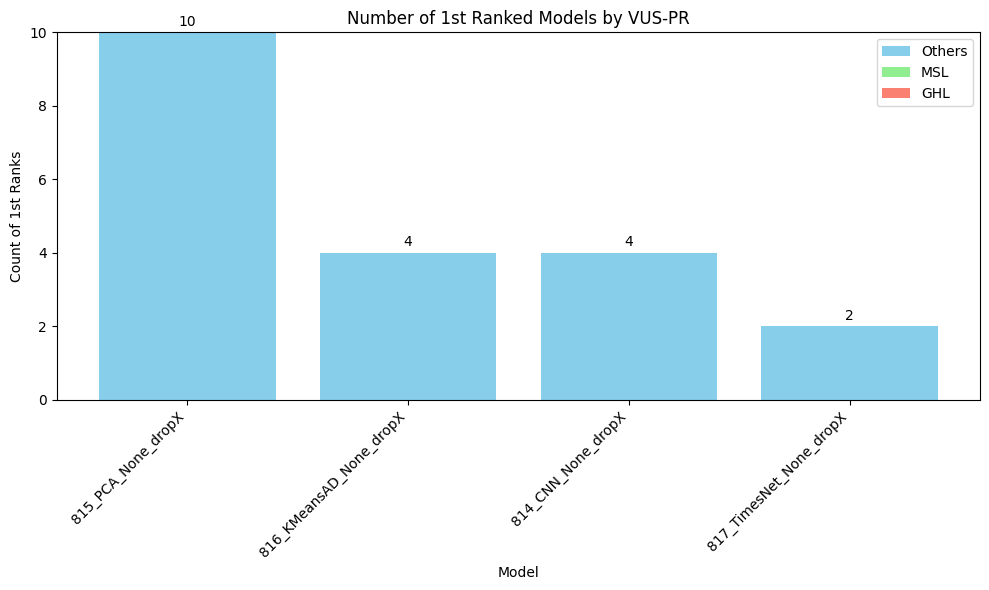

In [72]:
# 막대 그래프에 red_files와 green_files 안에 있는 시계열의 비중을 파악하기 위함
red_files = get_highlight_file_names(
    ['GHL']
)
green_files = get_highlight_file_names(
    ['MSL']
)

# red와 green에 대한 라벨 명시
plot_number_of_1st_ranked(red_files=red_files, green_files=green_files, red_label='GHL', green_label='MSL')

#### 2.3 히트맵 시각화
- `highlight_only`인자에 `False` 입력 시 강조하고 싶은 파일 이름이 있다면 붉게 표시됨
- `highlight_only`인자에 `True` 입력 시 강조하고 싶은 파일만 시각화됨

In [73]:
# 강조할 파일의 이름 또는 코드를 리스트에 추가
# Example
# 1) 키워드로 지정: file_name_to_include = ['001', '002', '040', ...] 또는 ['Genesis', 'MSL', ...]
# 2) 파일 이름으로 지정: file_name_to_include = ['001_Genesis_id_1_Sensor_tr_4055_1st_15538.csv', ...]
# 3) 정수 범위로 지정: file_name_to_include = [f'0{str(f_code):}' if f_code < 100 else f'{str(f_code)}' for f_code in list(range(100, 102))]
#file_name_to_include = [f'0{str(f_code):}' if f_code < 100 else f'{str(f_code)}' for f_code in list(range(100, 102))]
file_name_to_include = ['GHL']
highlight_file_names = get_highlight_file_names(file_name_to_include)

,814_CNN_None_dropX,815_PCA_None_dropX,816_KMeansAD_None_dropX,817_TimesNet_None_dropX,822_CNN_None_ns8-klr-ns4,823_PCA_None_ns8-klr-ns4,824_KMeansAD_None_ns8-klr-ns4,825_TimesNet_None_ns8-klr-ns4
Dataset,,,,,,,,
057_SMD_id_1_Facility_tr_4529_1st_4629.csv,0.217524,0.514548,0.274971,0.152590,0.192041,0.073036,0.073908,0.118011
058_SMD_id_2_Facility_tr_1087_1st_1187.csv,0.566966,0.656705,0.515771,0.397712,NaN,NaN,NaN,NaN
059_SMD_id_3_Facility_tr_757_1st_857.csv,0.411305,0.397708,0.416650,0.298022,NaN,NaN,NaN,NaN
060_SMD_id_4_Facility_tr_7176_1st_10609.csv,0.287518,0.572267,0.131538,0.367972,NaN,NaN,NaN,NaN
061_SMD_id_5_Facility_tr_7176_1st_15144.csv,0.145927,0.456526,0.182536,0.301717,NaN,NaN,NaN,NaN
063_SMD_id_7_Facility_tr_5923_1st_6506.csv,0.300384,0.567574,0.452030,0.326089,NaN,NaN,NaN,NaN
064_SMD_id_8_Facility_tr_2272_1st_2372.csv,0.275504,0.270768,0.396900,0.474982,NaN,NaN,NaN,NaN
065_SMD_id_9_Facility_tr_737_1st_837.csv,0.666248,0.440837,0.396342,0.262628,NaN,NaN,NaN,NaN
066_SMD_id_10_Facility_tr_2634_1st_2734.csv,0.281412,0.350131,0.484304,0.137748,NaN,NaN,NaN,NaN


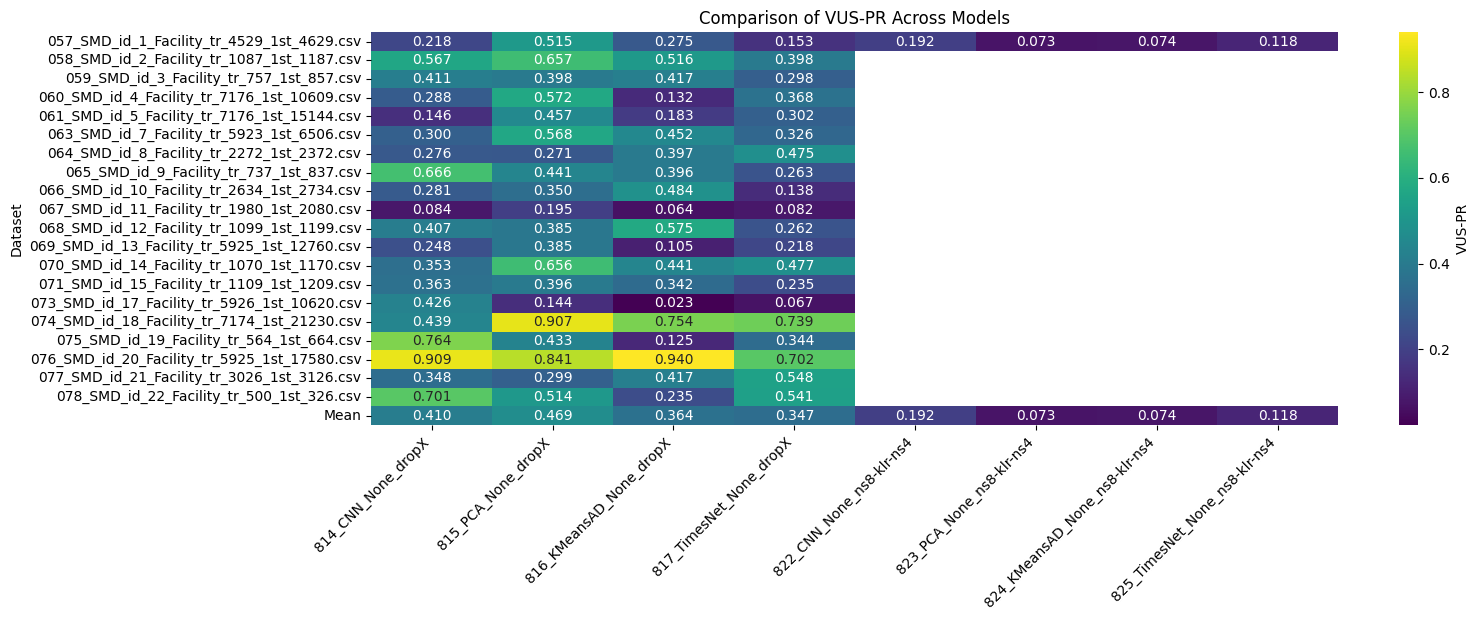

In [74]:
# 하이라이트를 포함하여 출력
plot_performance_heatmap(highlight_file_names=highlight_file_names, highlight_only=False)

/home/hwkang/anaconda3/envs/TSB-AD/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/hwkang/anaconda3/envs/TSB-AD/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/tmp/ipykernel_1986211/576546409.py:51: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


,814_CNN_None_dropX,815_PCA_None_dropX,816_KMeansAD_None_dropX,817_TimesNet_None_dropX,822_CNN_None_ns8-klr-ns4,823_PCA_None_ns8-klr-ns4,824_KMeansAD_None_ns8-klr-ns4,825_TimesNet_None_ns8-klr-ns4
Dataset,,,,,,,,
Mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


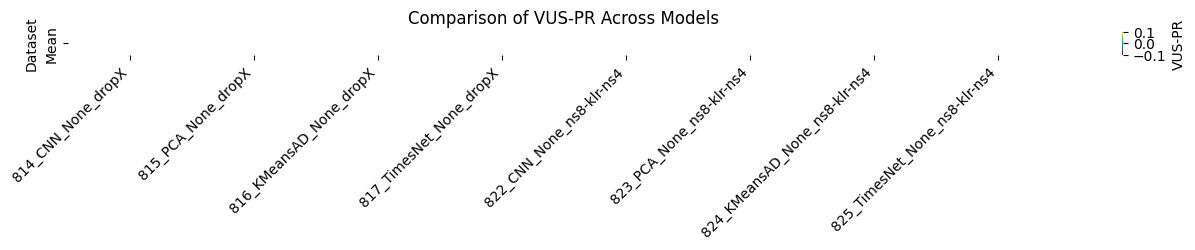

In [75]:
# 하이라이트 결과만 출력
plot_performance_heatmap(highlight_file_names=highlight_file_names, highlight_only=True)